This notebook evaluates the fitness of Inflight Fulfillment against historical component-poundage estimates. 

Predictions are evaluated on 

1. Directional correctness - is there a shortfall when one is predicted?
1. Relative magnitude - what is the prediction error as a function of mass
1. Absolute magnitude - what is the total poundage of error
1. Instance of 

Additionally, as predictions are evaluated for dates several weeks into the future, we'll evaluate predictions up to T+5

# Imports, etc.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import datetime 
import numpy as np
import os
from plotnine import *

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
import pandas as pd
pd.set_option('display.max_rows',500)

In [4]:
import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
def confusion_accuracy(sub_df):
    
    cm = confusion_matrix(y_true = sub_df['y_true'], y_pred=sub_df['y_pred'])
    
    accuracy = np.diagonal(cm / (cm.sum(axis=None))).sum()
    
    return pd.DataFrame([[accuracy, len(sub_df)]], columns=['accuracy','n'])

# Data

Recall that as we don't historically record shortfall in terms of component-poundage, this is not truly "actual" data but rather a reconstruction.

In [7]:
qry = """
    select * 
    from predict.m_inflight_fulfillment
    limit 10
"""
df = pd.read_sql(qry,conn)

In [8]:
df.head(n=3).transpose()

,0,1,2
FARM_ID,0,0,1
FACT_DATE,2019-12-06,2021-09-05,2022-02-18
REFERENCE_DATE,None,None,2022-02-18
COMPONENT_ID,12,12,16
COMPONENT_NAME,Butterhead,Butterhead,Flat Leaf Parsley
CASE_INVENTORY_LBS,NaN,NaN,21
BIN_INVENTORY_LBS,4.1932,4.1932,3.1482
RECENT_HARVEST_TO_PACK_PCT,NaN,NaN,71.8442
BIN_INVENTORY_PACKED_ESTIMATION_LBS,NaN,NaN,2.2618
PACKED_LBS,NaN,NaN,2.8125


## Inflight Fulfillment Predictions

In [9]:
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'
qry = f"""
    select *, 
      concat('Farm ',farm_id) as farm_str
    from predict.m_inflight_fulfillment
    where fact_date between '{START_DATE}' and '{END_DATE}'
      and is_backfill = true
      and code_version = '1.0.6'
    --qualify rank() over (partition by farm_id, component_id, fact_date, prediction_days_ahead order by computed_at desc) = 1
      and computed_at > '2022-07-22 13:00:00'
"""

data_df = pd.read_sql(qry,conn)

# Analysis

## Directional Correctness

### Overall

In [10]:
N_PREDICTION_DAYS_AHEAD = 5

directional_confusion_matrix = (
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .filter(items=['FARM_ID',
                   'FACT_DATE',
                   'COMPONENT_ID',
                   'COMPONENT_NAME',
                   'ANTICIPATED_SHORTFALL_LBS',
                   'PREDICTED_SHORTFALL_LBS_Q10',
                   'PREDICTED_SHORTFALL_LBS_Q50',
                   'PREDICTED_SHORTFALL_LBS_Q90'
                  ])
    .assign(anticipated_sign = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(predicted_q50_sign = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign))
    
    .pipe(lambda df: confusion_matrix(y_true=df['anticipated_sign'],y_pred=df['predicted_q50_sign']))
)

directional_confusion_matrix

array([[8922,  376, 1318],
       [ 820, 3104,  348],
       [3477,  223, 3254]])

In [11]:
N_PREDICTION_DAYS_AHEAD = 5

directional_confusion_matrix_interpretation = (
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .filter(items=['FARM_ID',
                   'FACT_DATE',
                   'COMPONENT_ID',
                   'COMPONENT_NAME',
                   'ANTICIPATED_SHORTFALL_LBS',
                   'PREDICTED_SHORTFALL_LBS_Q10',
                   'PREDICTED_SHORTFALL_LBS_Q50',
                   'PREDICTED_SHORTFALL_LBS_Q90'
                  ])
    .assign(anticipated_sign = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(predicted_q50_sign = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign))
        
    .groupby(['anticipated_sign','predicted_q50_sign'],as_index=False)
    .size()
)

directional_confusion_matrix_interpretation

,anticipated_sign,predicted_q50_sign,size
0,-1.0,-1.0,8922
1,-1.0,0.0,376
2,-1.0,1.0,1318
3,0.0,-1.0,820
4,0.0,0.0,3104
5,0.0,1.0,348
6,1.0,-1.0,3477
7,1.0,0.0,223
8,1.0,1.0,3254


In [12]:
(directional_confusion_matrix / (directional_confusion_matrix.sum(axis=None))).round(2)

array([[0.41, 0.02, 0.06],
       [0.04, 0.14, 0.02],
       [0.16, 0.01, 0.15]])

In [13]:
# Accuracy (sum of the diagonal)
np.diagonal(directional_confusion_matrix / (directional_confusion_matrix.sum(axis=None))).sum()

0.6995696364801758

### Overall By Farm, Component and Prediction Days Ahead

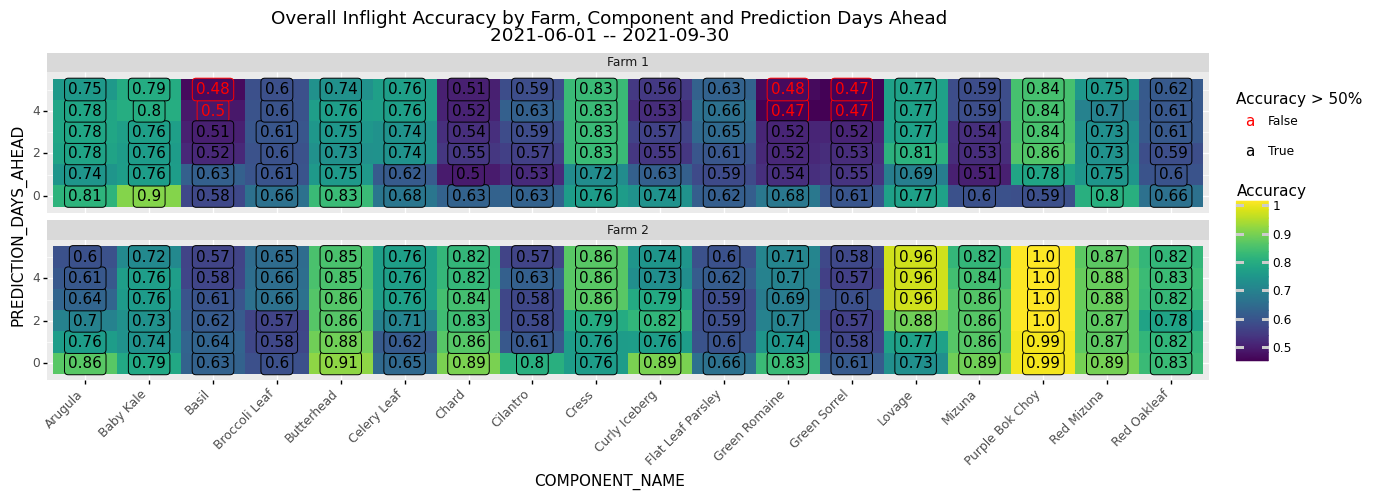

<ggplot: (360472941)>

In [21]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    
    .assign(y_true = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(y_pred = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign))
    
    .groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])
    .apply(confusion_accuracy)
    .reset_index()
    .query('n > @DAYS_OBSERVED')
    
    .assign(accuracy_gr_50 = lambda x: x['accuracy'] > .5)
    .assign(accuracy_2 = lambda x: np.round(x['accuracy'],2).astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='PREDICTION_DAYS_AHEAD', fill='accuracy', label='accuracy_2'))
         + geom_tile()
         + geom_label(aes(color='accuracy_gr_50'))
         + scale_color_manual(values=['red','black'])
         + facet_wrap('FARM_STR',ncol=1)
         + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45)))
         + labs(color='Accuracy > 50%', fill='Accuracy')
         + ggtitle(f"Overall Inflight Accuracy by Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
)

### Identify Shortfalls (Recall) vs Anticipated

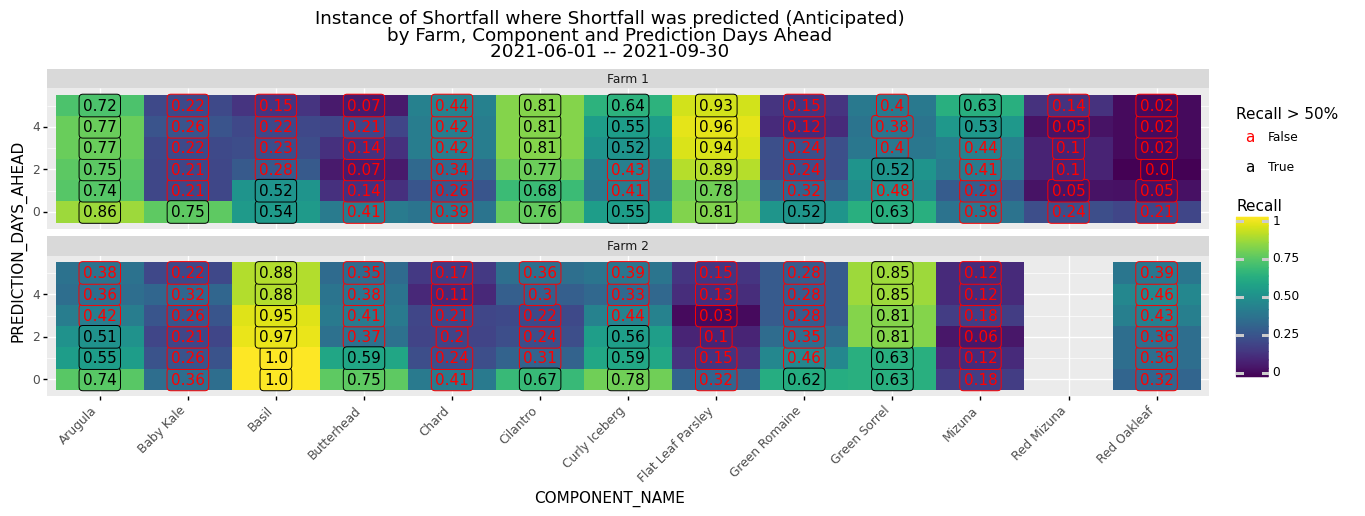

<ggplot: (359662830)>

In [15]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    
    .assign(y_true = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(y_pred = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign) > 0)
    
    .query('y_true > 0')
    .groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])
    .agg(recall = pd.NamedAgg('y_pred','mean'),
         n      = pd.NamedAgg('y_pred','size'))
    .reset_index()
    .query('n > @DAYS_OBSERVED')
    
    .assign(recall_gr_50 = lambda x: x['recall'] > .5)
    .assign(recall_2 = lambda x: np.round(x['recall'],2).astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='PREDICTION_DAYS_AHEAD', fill='recall', label='recall_2'))
         + geom_tile()
         + geom_label(aes(color='recall_gr_50'))
         + scale_color_manual(values=['red','black'])
         + facet_wrap('FARM_STR',ncol=1)
         + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45)))
         + labs(color='Recall > 50%', fill='Recall')
         + ggtitle(f"Instance of Shortfall where Shortfall was predicted (Anticipated)\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
)

### Identify Surplus (Recall) vs Anticipated

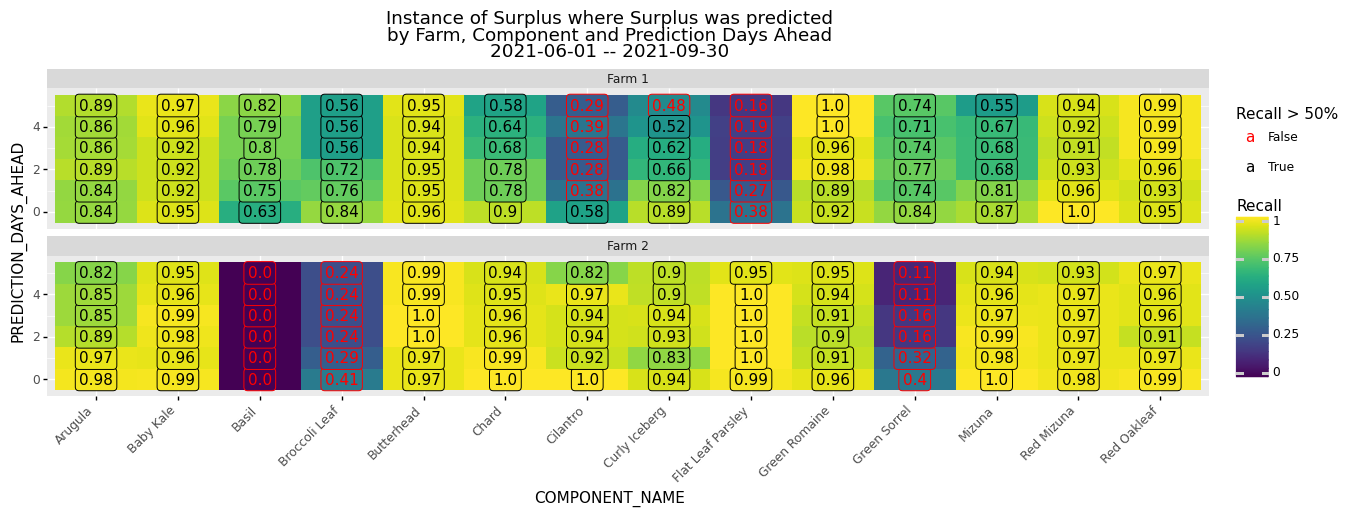

<ggplot: (360591836)>

In [16]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    
    .assign(y_true = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(np.sign))
    .assign(y_pred = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign) < 0)
    
    .query('y_true < 0')
    .groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])
    .agg(recall = pd.NamedAgg('y_pred','mean'),
         n      = pd.NamedAgg('y_pred','size'))
    .reset_index()
    .query('n > @DAYS_OBSERVED')
    
    .assign(recall_gr_50 = lambda x: x['recall'] > .5)
    .assign(recall_2 = lambda x: np.round(x['recall'],2).astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='PREDICTION_DAYS_AHEAD', fill='recall', label='recall_2'))
         + geom_tile()
         + geom_label(aes(color='recall_gr_50'))
         + scale_color_manual(values=['red','black'])
         + facet_wrap('FARM_STR',ncol=1)
         + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45)))
         + labs(color='Recall > 50%', fill='Recall')
         + ggtitle(f"Instance of Surplus where Surplus was predicted\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
)

### Identify Shortfalls (Recall) vs Line Items

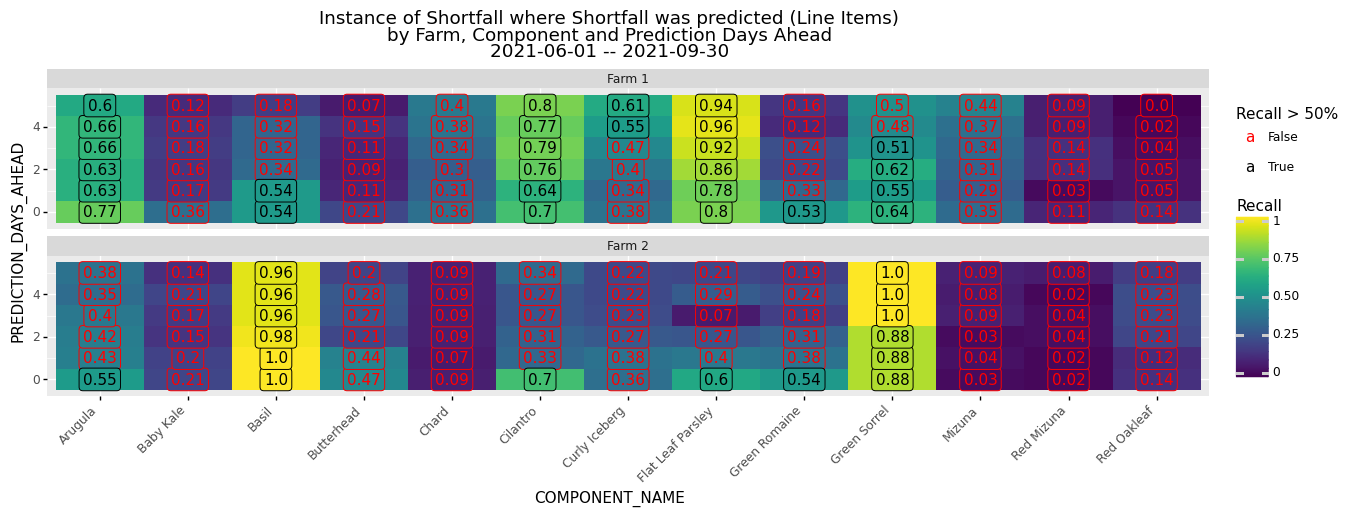

<ggplot: (360829802)>

In [17]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    
    .assign(y_true = lambda x: x['SHORTFALL_LBS'].apply(np.sign))
    .assign(y_pred = lambda x: x['PREDICTED_SHORTFALL_LBS_Q50'].apply(np.sign) > 0)
    
    .query('y_true > 0')
    .groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])
    .agg(recall = pd.NamedAgg('y_pred','mean'),
         n      = pd.NamedAgg('y_pred','size'))
    .reset_index()
    .query('n > @DAYS_OBSERVED')
    
    .assign(recall_gr_50 = lambda x: x['recall'] > .5)
    .assign(recall_2 = lambda x: np.round(x['recall'],2).astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='PREDICTION_DAYS_AHEAD', fill='recall', label='recall_2'))
         + geom_tile()
         + geom_label(aes(color='recall_gr_50'))
         + scale_color_manual(values=['red','black'])
         + facet_wrap('FARM_STR',ncol=1)
         + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45)))
         + labs(color='Recall > 50%', fill='Recall')
         + ggtitle(f"Instance of Shortfall where Shortfall was predicted (Line Items)\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
)

## Relative Magnitude

In [18]:
def round_up(x):
    if x == 0:
        return 1
    elif abs(x) > 0 and abs(x) < 1:
        return 1*np.sign(x)
    else:
        return x

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


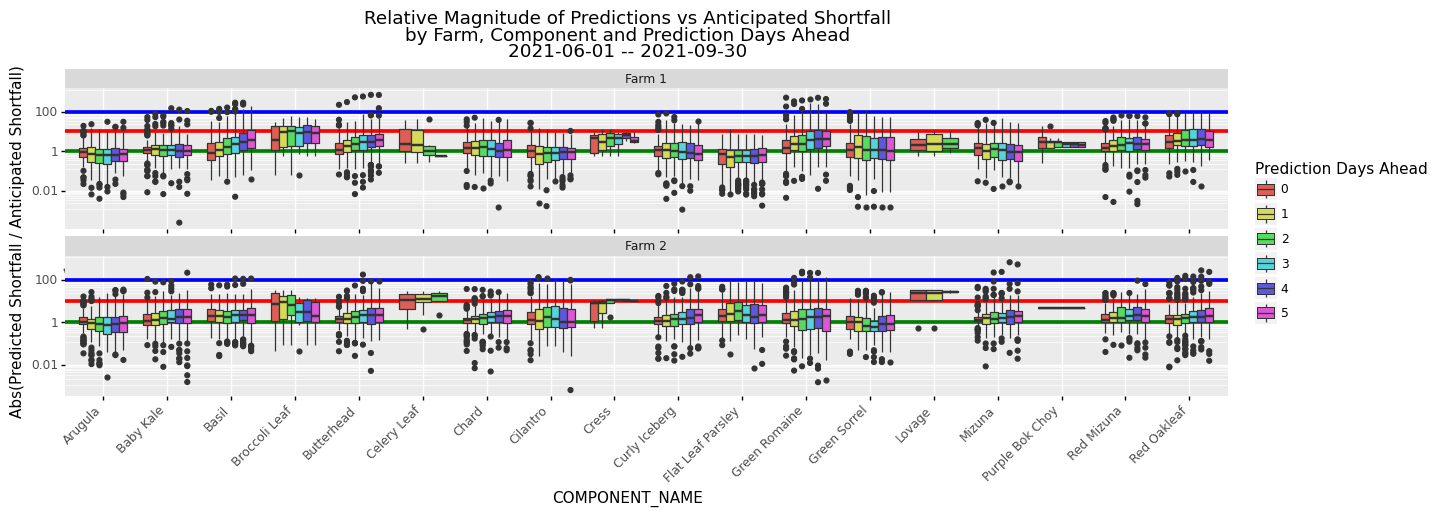

<ggplot: (360820080)>

In [19]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    
    .assign(n = lambda df: df.groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])['FARM_STR'].transform('size'))
    .assign(pred_str = lambda x: x['PREDICTION_DAYS_AHEAD'].astype(str))
    
    # Where the anticipated shortfall is between 0 and 1, make it 1 
    .assign(ANTICIPATED_SHORTFALL_CORRECTED = lambda x: x['ANTICIPATED_SHORTFALL_LBS'].apply(round_up))
    .assign(relative_magnitude = lambda x: np.abs(x['PREDICTED_SHORTFALL_LBS_Q50'] / (x['ANTICIPATED_SHORTFALL_CORRECTED']))) 
    
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .query('n > @DAYS_OBSERVED')  
    
    # drop a few outliers that break the plot
    .query("relative_magnitude > 1e-12")

    .reset_index()

    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='relative_magnitude',fill='pred_str'))
          + geom_hline(yintercept=1,color='green',size=1.5)
          + geom_hline(yintercept=10,color='red',size=1.5)
          + geom_hline(yintercept=100,color='blue',size=1.5)
          + geom_boxplot(position='dodge')


          + scale_y_log10()
          + labs(y="Abs(Predicted Shortfall / Anticipated Shortfall)", fill='Prediction Days Ahead')
          + facet_wrap('FARM_STR',ncol=1,scales='free')
          + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45))
          
          + ggtitle(f"Relative Magnitude of Predictions vs Anticipated Shortfall\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
         )

)

## Absolute Magnitude

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


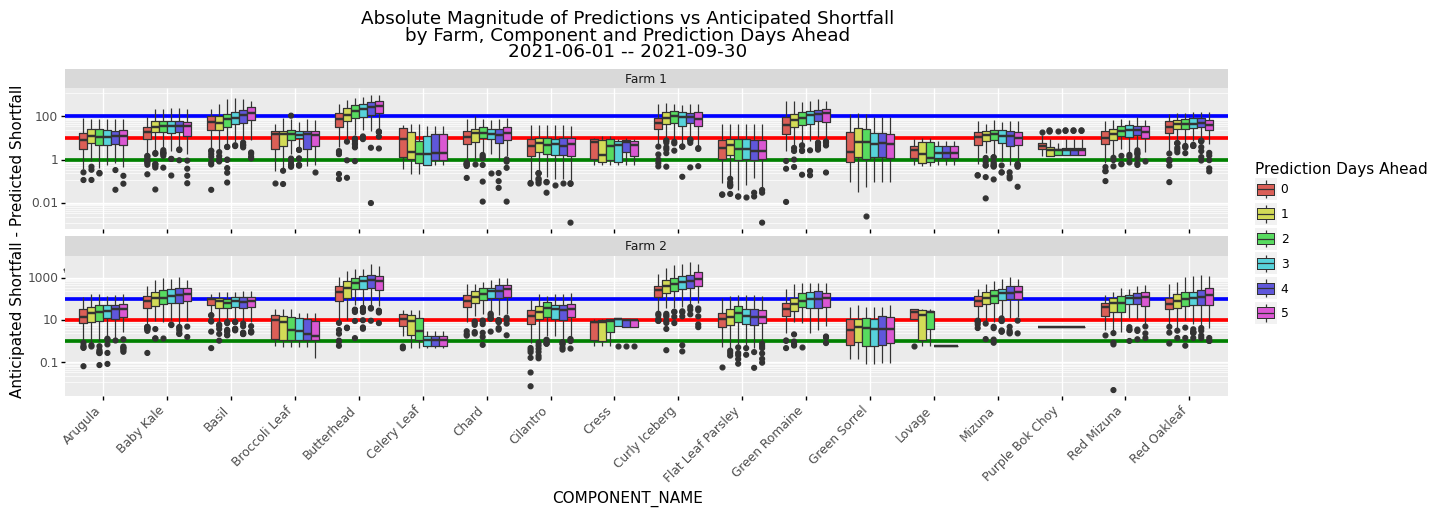

<ggplot: (360568920)>

In [20]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 5
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    
    .assign(n = lambda df: df.groupby(['FARM_STR','COMPONENT_ID','COMPONENT_NAME','PREDICTION_DAYS_AHEAD'])['FARM_STR'].transform('size'))
    .assign(pred_str = lambda x: x['PREDICTION_DAYS_AHEAD'].astype(str))
    
    .assign(absolute_magnitude = lambda x: np.abs(x['ANTICIPATED_SHORTFALL_LBS'] - x['PREDICTED_SHORTFALL_LBS_Q50']))
    
    
    .query('PREDICTION_DAYS_AHEAD <= @N_PREDICTION_DAYS_AHEAD')
    .query('n > @DAYS_OBSERVED')  

    .reset_index()
    
    # clear a handful of outliers to make F2 display better
    .query('absolute_magnitude > 1e-6')

    .pipe(lambda df: ggplot(df, aes(x='COMPONENT_NAME',y='absolute_magnitude',fill='pred_str'))
          + geom_hline(yintercept=1,  color='green',size=1.5)
          + geom_hline(yintercept=10, color='red',size=1.5)
          + geom_hline(yintercept=100,color='blue',size=1.5)
          + geom_boxplot(position='dodge')

          + scale_y_log10()
          + labs(y="Anticipated Shortfall - Predicted Shortfall", fill='Prediction Days Ahead')
          + facet_wrap('FARM_STR',ncol=1,scales='free')
          + theme(figure_size=(15,4), axis_text_x=element_text(hjust=1,rotation=45))
          
          + ggtitle(f"Absolute Magnitude of Predictions vs Anticipated Shortfall\nby Farm, Component and Prediction Days Ahead\n{START_DATE} -- {END_DATE}")
         )

)